In [1]:
!pip install -q kaggle

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = 'patcharapornsirimom'
os.environ['KAGGLE_KEY'] = 'f210b973a549333dff65bf7c3c748a54'

In [ ]:
!kaggle competitions download -c diabetic-retinopathy-classification-for-superai-3

In [ ]:
!unzip diabetic-retinopathy-classification-for-superai-3.zip

### import library

In [3]:
import pandas as pd 
import numpy as np 
import glob
import shutil
import os
import seaborn as sns 
import cv2
import random
import pathlib
import json
import cv2
import matplotlib.pyplot as plt 
from scipy.stats import norm
import statistics
import random
import shutil

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras import layers
# from tensorflow.keras.layers import Input
from tensorflow import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.callbacks import ReduceLROnPlateau
# from tensorflow.keras import models
# from tensorflow.keras import optimizers
from keras.layers import Input
from keras.models import Model
from keras.applications import VGG16
from keras.layers import Flatten, Dropout, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
train_df = pd.read_csv("./Train.csv")

In [5]:
train_df

,id_code,diagnosis
0,Train_1,2
1,Train_2,2
2,Train_3,4
3,Train_4,2
4,Train_5,3
...,...,...
4204,Train_4205,2
4205,Train_4206,2
4206,Train_4207,2
4207,Train_4208,0


<AxesSubplot:>

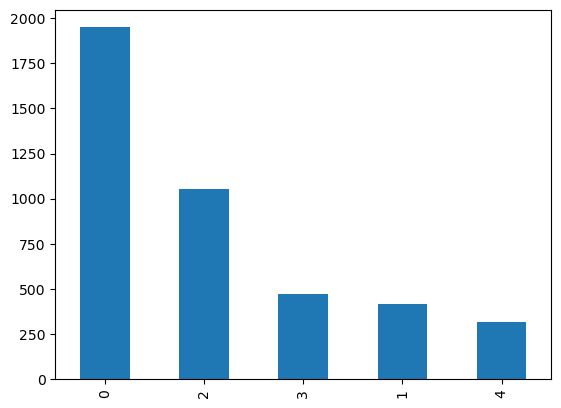

In [6]:
pd.value_counts(train_df['diagnosis']).plot.bar()

0 - No DR หรือ ไม่มีภาวะเบาหวานขึ้นจอประสาทตา

1 - Mild NPDR (mild non-proliferative diabetic retinopathy) หรือ ภาวะเบาหวานเข้าจอประสาทตาขั้นเบา

2 - Moderate NPDR (moderate non-proliferative diabetic retinopathy) หรือ ภาวะเบาหวานเข้าจอประสาทตาขั้นปานกลาง

3 - Severe NPDR (severe non-proliferative diabetic retinopathy) หรือ ภาวะเบาหวานเข้าจอประสาทตาขั้นรุนแรง

4 - PDR (proliferative diabetic retinopathy) หรือ ภาวะเบาหวานเข้าจอประสาทตาที่มีเส้นเลือดงอกใหม่

#### Data Cleaning

Copy image from dataframe seperate into folder

In [7]:
traindir = "./trainset/"

[1948, 420, 1051, 473, 317]
max is  1948 
min is  317


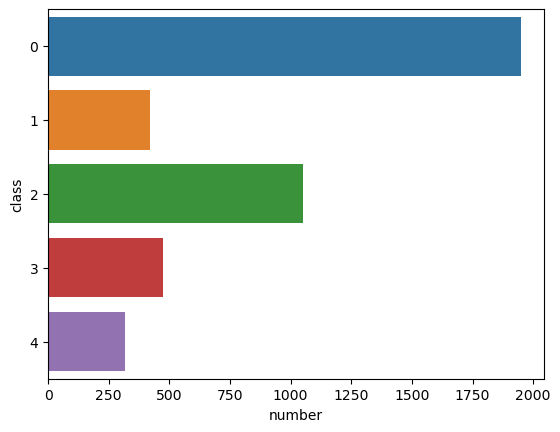

In [8]:
#### Before augment
class_names = ["0", "1", "2", "3", "4"]
count=[]
for number in class_names :
    count.append(len(os.listdir(traindir+number)))
print(count)

df = pd.DataFrame({'class':class_names, 'number':count})
g=sns.barplot(data=df,x='number', y='class')

print('max is ',max(count),'\nmin is ',min(count))

In [9]:
tf.get_logger().setLevel('ERROR')

In [10]:
batch_size = 64
img_height = 224
img_width = 224

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255,
    featurewise_center=True,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode="nearest",
    zoom_range=0.1,
    rotation_range=45)

In [12]:
fit_images = ImageDataGenerator(rescale=1./255,
    horizontal_flip=True,
    fill_mode = "nearest",
    zoom_range = 0.1,
    rotation_range=45).flow_from_directory( 
            traindir, 
            target_size = (img_height, img_width), 
            batch_size = batch_size, # the featurewise_center will be based off 1000 images 
            seed = 123)
fit_images, fit_labels = next(fit_images)
train_datagen.fit(fit_images,
                 seed = 123,
                 augment = True)

Found 4209 images belonging to 5 classes.


In [13]:
train_generator = train_datagen.flow_from_directory(
    traindir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123,
    class_mode="categorical",
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    traindir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123,
    class_mode="categorical",
    subset='validation') # set as validation data

Found 3369 images belonging to 5 classes.
Found 840 images belonging to 5 classes.


In [14]:
vgg_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))
x = vgg_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dense(5, activation='softmax')(x) # Softmax for multiclass

transfer_model = Model(inputs=vgg_model.input, outputs=x)

In [15]:
for layer in transfer_model.layers[:19]:
    layer.trainable = False
# Make sure you have frozen the correct layers
for i, layer in enumerate(transfer_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False
19 flatten True
20 dense True
21 dropout True
22 dense_1 True
23 dense_2 True


In [16]:
transfer_model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
checkpoint = ModelCheckpoint("VGG16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

model_hist2 = transfer_model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 100,
    callbacks = [checkpoint, early])

C:\Users\babyt\AppData\Local\Temp\ipykernel_14812\974002895.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_hist2 = transfer_model.fit_generator(


Epoch 1/30
 1/52 [..............................] - ETA: 22:06 - loss: 2.0929 - accuracy: 0.1951

KeyboardInterrupt: 